## metrics & merge:
- calc a distance, avg. speed?, directionality (N,E,S,W) 
- merge to socio-demographic data?

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from shapely.geometry import LineString, Point
import shapely.wkt
import mplleaflet
import math

import sys
sys.path.append('../utils')
import direction_functions; # functions for calculating direction and magnitude of linestrings
import spatial_functions # functions for calculating direction and magnitude of linestrings

%matplotlib inline

In [ ]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")

In [ ]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]

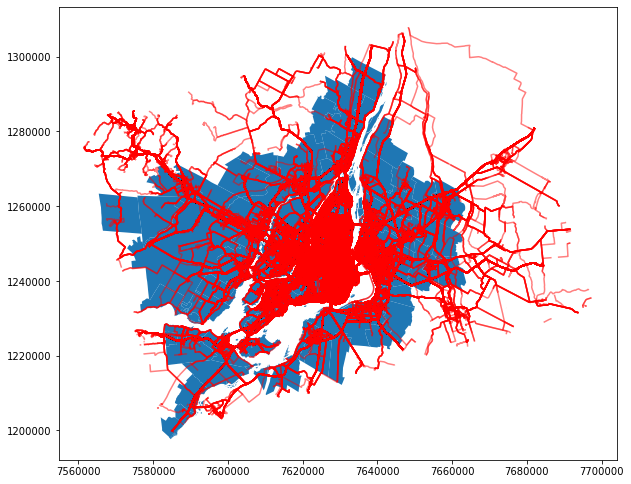

In [18]:
fig, ax = plt.subplots(1, figsize=(10,10))
mtl_greater.plot(ax=ax)
gdf.plot(ax=ax, color='r', alpha=.5)

In [9]:
CAN_LAM = {'init': 'epsg:3347'}

In [ ]:
gdf.plot()

In [164]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,starthour,endhour,weekday,start_rush,end_rushho,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,...,0,0,1,0,1,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,...,2,2,1,0,1,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,...,5,5,1,0,1,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,...,6,6,1,0,1,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,...,6,6,1,0,1,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


In [6]:
if 'seconds' not in gdf.columns:
    gdf['seconds'] = pd.to_datetime(gdf['endtime']) - pd.to_datetime(gdf['starttime'])
    gdf['seconds'] = gdf.seconds.apply(lambda tm: tm.seconds)
    # gdf[["id_trip","mode","purpose","starttime","endtime","seconds","geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')

In [3]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 185285 entries, 0 to 185284
Data columns (total 25 columns):
id_trip       185285 non-null int64
mode          74218 non-null object
purpose       74218 non-null object
starttime     185285 non-null object
endtime       185285 non-null object
seconds       185285 non-null int64
distance_m    185285 non-null float64
direction     185285 non-null float64
magnitude     185285 non-null float64
carddir       185285 non-null object
start_down    185285 non-null int64
end_downto    185285 non-null int64
starthour     185285 non-null int64
endhour       185285 non-null int64
weekday       185285 non-null object
startrush     185285 non-null int64
endrush       185285 non-null int64
thrurush      185285 non-null int64
lda_word      74218 non-null object
temporal_c    185285 non-null int64
start_wgs     185285 non-null object
end_wgs       185285 non-null object
start_can     185285 non-null object
end_can       185285 non-null object
geo

In [8]:
gdf.seconds.describe()

count    185285.000000
mean       1531.031454
std        1487.144484
min           1.000000
25%         576.000000
50%        1164.000000
75%        2049.000000
max       83858.000000
Name: journeytime, dtype: float64

Text(0.5, 0, 'journey time (mins)')

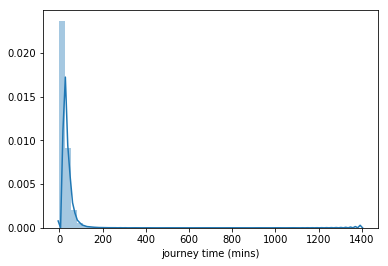

In [9]:
sns.distplot(gdf.seconds/60,hist=True)
plt.xlabel("journey time (mins)")

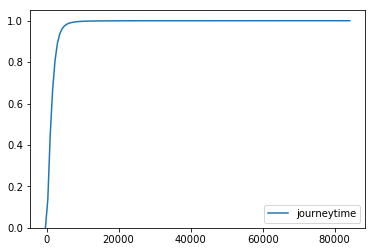

In [10]:
try:
    sns.kdeplot(gdf.seconds,cumulative=True)
except:
    print("failed")

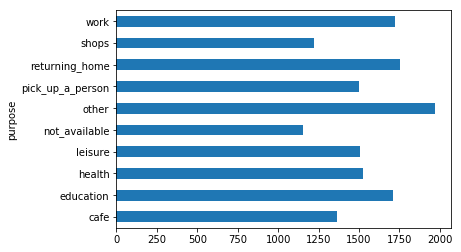

In [11]:
gdf.groupby(["purpose"]).mean().seconds.plot.barh()

## Distance and projection

In [ ]:
## convert to Canada Lambert Projection (https://epsg.io/3347)
if gdf.crs != CAN_LAM:
    print("translating data")
    gdf = gdf.to_crs(crs=CAN_LAM)
else:
    print("correct crs")

In [13]:
## convert to Canada Lambert Projection (https://epsg.io/3347)
if mtl_greater.crs != CAN_LAM:
    print("translating data")
    mtl_greater = mtl_greater.to_crs(CAN_LAM)
else:
    print("correct crs")


correct crs


In [ ]:
if not 'distance_m' in gdf.columns:
    print("calculating distance")
    gdf['distance_m'] = gdf['geometry'].apply(lambda row: row.length)
else:
    print('distance already calculated')

In [ ]:
## save file
# gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')

## Direction

##### Summary
   uses functions that calculate the resultant and magnitude from a collection of vector (from `direction_functions.py`)
   
Note: this section has been reduced to a python file for readibility

In [6]:
## change crs back to WGS84 for direction calc
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [88]:
assert gdf.crs == {'init': 'epsg:4326'}, "Please convert the data into {'init':'epsg:4326'} using geopandas .to_crs function"
for i in range(10):
    print(direction_functions.mean_direction(gdf.geometry[i]))

(303.57297974430526, 0.01900323295156603)
(274.07921591790466, 0.31350462546590097)
(130.69109770740806, 0.27210367947612435)
(85.31096874673939, 0.30408573820879076)
(96.63069888827931, 0.25548529306597)
(66.28637728773492, 0.32517836533528893)
(225.25857964722175, 0.4075196673306976)
(123.19165929830878, 0.32566237062755155)
(13.24033658237791, 0.29355584759280146)
(34.37338810679028, 0.257251746879844)


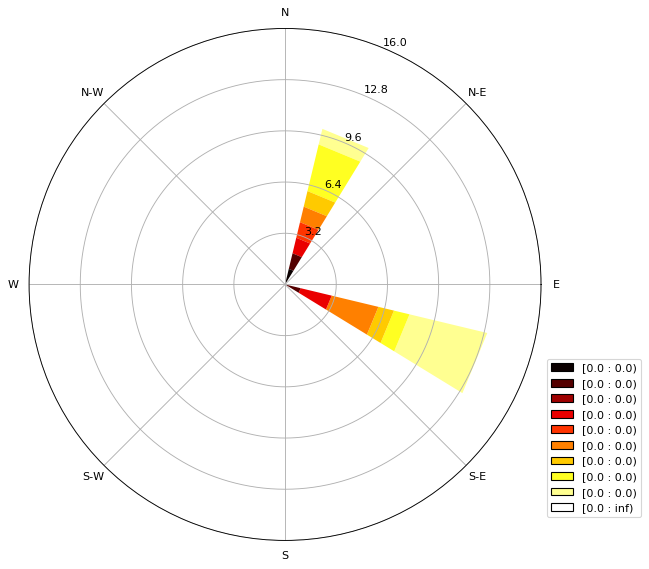

87.86253085866772 0.2573491043649242
cardinal direction of resultant = E


In [89]:
res_dir, res_mag = direction_functions.mean_direction(gdf.geometry[10], True)
print(res_dir, res_mag)
print("cardinal direction of resultant =", direction_functions.cardinal_direction(res_dir))

In [90]:
%%time
# takes around 5 mins
gdf['dir_mag'] = gdf.geometry.apply(direction_functions.mean_direction)

CPU times: user 5min 24s, sys: 2.03 s, total: 5min 26s
Wall time: 5min 34s


In [91]:
gdf_dir_mag = gdf.dir_mag.apply(pd.Series)

In [92]:
gdf_dir_mag.columns = ["direction","magnitude"]
gdf = pd.concat([gdf[gdf.columns[:-1]],gdf_dir_mag], axis=1)

In [98]:
gdf['carddir'] = gdf.direction.apply(direction_functions.cardinal_direction)

In [6]:
## calculate start and end points (WGS84)
gdf = gdf.to_crs(crs={'init':'epsg:4326'})
gdf['start_wgs'] =  gdf.geometry.apply(spatial_functions.get_point_from_linestring, X=0) 
gdf['end_wgs'] =  gdf.geometry.apply(spatial_functions.get_point_from_linestring, X=-1) 

In [7]:
## calculate start and end points (Canada Lambert)
gdf = gdf.to_crs(CAN_LAM)
gdf['start_can'] =  gdf.geometry.apply(spatial_functions.get_point_from_linestring, X=0) 
gdf['end_can'] =  gdf.geometry.apply(spatial_functions.get_point_from_linestring, X=-1) 

In [8]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 04:16:58UTC,2017-09-18 04:26:26UTC,568,1530.222174,303.572980,0.019003,WNW,"(-73.65116600000005, 45.54450099999979)","(-73.65475300000004, 45.5455209999998)","(7624015.797731058, 1247372.3591223992)","(7623710.593941391, 1247402.4239209683)",LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 06:17:46UTC,2017-09-18 06:58:49UTC,2463,324.869460,274.079216,0.313505,W,"(-73.65098700000003, 45.54449599999979)","(-73.65475300000004, 45.5455209999998)","(7624029.565886399, 1247375.8256112537)","(7623710.593941391, 1247402.4239209683)",LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 09:30:24UTC,2017-09-18 10:17:28UTC,2824,32009.701647,130.691098,0.272104,SE,"(-73.79999600000002, 45.63632099999982)","(-73.62417100000005, 45.53094099999978)","(7609795.133960674, 1253993.0596227613)","(7626500.696944128, 1246510.1413189245)",(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 10:02:50UTC,2017-09-18 10:17:12UTC,862,9935.922336,85.310969,0.304086,E,"(-73.64638500000002, 45.546289999999786)","(-73.54531800000002, 45.55066099999977)","(7624322.265039737, 1247672.970059534)","(7631863.767736516, 1250414.940902869)",LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 10:18:40UTC,2017-09-18 10:27:44UTC,544,563.806088,96.630699,0.255485,E,"(-73.74527300000005, 45.55845599999979)","(-73.72059400000005, 45.559500999999784)","(7616417.181546402, 1246781.286979011)","(7618260.407733496, 1247444.3120862804)",(LINESTRING (7616402.393582945 1246769.1996916...


In [9]:
gdf['start_wgs'] = gdf['start_wgs'].apply(Point)
gdf['start_can'] = gdf['start_can'].apply(Point)
gdf['end_wgs'] = gdf['end_wgs'].apply(Point)
gdf['end_can'] = gdf['end_can'].apply(Point)

In [10]:
# stringify points
gdf['start_wgs'] = gdf['start_wgs'].apply(str)
gdf['start_can'] = gdf['start_can'].apply(str)
gdf['end_wgs'] = gdf['end_wgs'].apply(str)
gdf['end_can'] = gdf['end_can'].apply(str)

In [11]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 04:16:58UTC,2017-09-18 04:26:26UTC,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 06:17:46UTC,2017-09-18 06:58:49UTC,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 09:30:24UTC,2017-09-18 10:17:28UTC,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 10:02:50UTC,2017-09-18 10:17:12UTC,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 10:18:40UTC,2017-09-18 10:27:44UTC,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


### Change the time-zone

In [61]:
import pytz
import time

In [ ]:
pytz.

In [83]:
%%time
# eastern daylight time conversion from UTC (UTC is +4 from DST)
EDT = pytz.timezone('Canada/Eastern')

gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [78]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 04:16:58+00:00,2017-09-18 04:26:26+00:00,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 06:17:46+00:00,2017-09-18 06:58:49+00:00,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 09:30:24+00:00,2017-09-18 10:17:28+00:00,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 10:02:50+00:00,2017-09-18 10:17:12+00:00,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 10:18:40+00:00,2017-09-18 10:27:44+00:00,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


In [80]:
gdf['starttime'] = gdf['starttime'].apply(lambda tm: tm.astimezone(EDT))
gdf['endtime'] = gdf['endtime'].apply(lambda tm: tm.astimezone(EDT))

In [81]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


In [87]:
# stringify the data ready to be saved
gdf['starttime'] = gdf['starttime'].apply(str)
gdf['endtime'] = gdf['endtime'].apply(str)

## save main data

In [89]:
## save file
gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_wgs","end_wgs","start_can","end_can", "geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.json", encoding='utf-8', driver='GeoJSON')

# Other data

In [ ]:
try:
    mtl_culture_sites = pd.read_csv('../data/lieuxculturels.csv')
except:
    print("file deleted")
    mtl_culture_sites = gpd.read_file('../data/lieuxculturels.csv')
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')
mtl_roads = gpd.read_file('../data/mtl_roads.json')
mtl_parking_stations = gpd.read_file('../data/signalisation_stationnement.geojson')
mtl_regions = gpd.read_file("../../MSc_Spatial_Systems/CASA0006_FinalAssignment_18110348/CASA0006_FinalAssessment_18110348/datasets/montreal_neighbourhood.json")

## Change projection of other data

In [ ]:
mtl_culture_sites.head(2) ## needs Point creation, gpd.DataFrame,  then to_crs

In [ ]:
mtl_roads.head(2) ## to_crs

In [ ]:
parking_stations.head(2) ## to_crs

In [ ]:
mtl_culture_sites

In [ ]:
## make into geoDataFrame
if not type(mtl_culture_sites) == gpd.GeoDataFrame:
    mtl_culture_sites['geometry'] = mtl_culture_sites.apply(lambda row: Point(row['Longitude'],row["Latitude"]), axis=1)
    mtl_culture_sites = gpd.GeoDataFrame(mtl_culture_sites, crs={'init':'epsg:4326'})

In [ ]:
type(mtl_culture_sites) == gpd.GeoDataFrame

In [ ]:
# convert data to Canada Lambert Projection (https://epsg.io/3347)
mtl_culture_sites = spatial_functions.change_crs(mtl_culture_sites, "mtl_culture_sites", CAN_LAM)
mtl_land_use = spatial_functions.change_crs(mtl_land_use, "mtl_land_use", CAN_LAM)
mtl_roads = spatial_functions.change_crs(mtl_roads, "mtl_roads", CAN_LAM)
mtl_parking_stations = spatial_functions.change_crs(mtl_parking_stations, "parking_stations", CAN_LAM)
mtl_regions = spatial_functions.change_crs(mtl_regions, "mtl_regions", CAN_LAM)

In [ ]:
## remove 3rd dim
# mtl_building_density['geometry'] = mtl_building_density['geometry'].apply(lambda poly: spatial_functions.remove_third_dimension(poly))

In [ ]:
# convert the data into multipolygons if not already
mtl_land_use['geometry'] = mtl_land_use['geometry'].apply(lambda poly: MultiPolygon([poly]) if type(poly) == Polygon else poly)

### re-save the files

In [54]:
# %%time
# mtl_regions.to_file('../shapes/mtl_regions.json', driver="GeoJSON")
# mtl_culture_sites.to_file('../data/lieuxculturels.json', driver="GeoJSON")
# mtl_roads.to_file('../data/mtl_roads.json', driver="GeoJSON")
# mtl_parking_stations.to_file('../data/signalisation_stationnement.geojson', driver="GeoJSON")
# mtl_greater.to_file("../shapes/greater_montreal.geojson", encoding='utf-8', driver='GeoJSON')

In [ ]:
# %%time
# mtl_land_use.to_file('../data/mtl_land_use.json', driver="GeoJSON")

## other geojsons and shapefiles

In [35]:
# large areas
mtl_regions = gpd.read_file("../shapes/mtl_regions.json")
mtl_outside_regions = gpd.read_file("../shapes/mtl_smaller_regions.geojson")

# small areas
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")

In [37]:
help(spatial_functions.change_crs)

Help on function change_crs in module spatial_functions:

change_crs(data, crs, data_name)
    changes the crs of the
    
    Parameters
    ----------
    data : geopandas.geodataframe.GeoDataFrame
        dataframe that is going
    crs : dictionary
        in the format {'init' :'epsg:????'}
    data_name : string
        name of the dataframe
    
    Returns
    -------
    grouped_data :geopandas.geodataframe.GeoDataFrame



In [40]:
mtl_regions = spatial_functions.change_crs(data=mtl_regions, data_name="mtl_regions",crs=CAN_LAM)
mtl_outside_regions = spatial_functions.change_crs(data=mtl_outside_regions, data_name="mtl_outside_regions",crs=CAN_LAM)
mtl_dissem = spatial_functions.change_crs(data=mtl_dissem, data_name="mtl_dissem",crs=CAN_LAM)

correct crs for mtl_regions
translating mtl_outside_regions data
translating mtl_dissem data


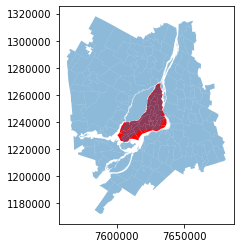

In [67]:
fig, ax = plt.subplots(1)
mtl_regions.plot(ax=ax, color='red')
mtl_outside_regions.plot(ax=ax, alpha=.5)

In [68]:
mtl_outside_regions = mtl_outside_regions[~(mtl_outside_regions.within(mtl_regions.cascaded_union)) & ~(mtl_outside_regions.overlaps(mtl_regions.cascaded_union))]

In [78]:
mtl_regions = mtl_outside_regions.append(mtl_regions, sort=True)
mtl_regions.reset_index(inplace=True)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [ ]:
mtl_regions.reset_index(inplace=True)
mtl_regions.rename(columns={'index':'ID'}, inplace=True)

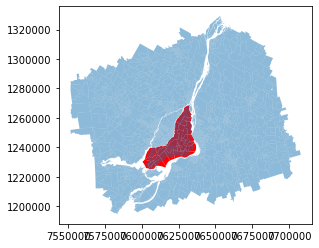

In [43]:
fig, ax = plt.subplots(1)
mtl_regions.plot(ax=ax, color='red')
mtl_dissem.plot(ax=ax, alpha=.5)

In [44]:
# mtl_regions.to_file("../shapes/mtl_all_regions.json", driver='GeoJSON')
# mtl_dissem.to_file("../shapes/mtl_dissem.geojson", driver='GeoJSON')

## Pre-process the other data

In [ ]:
## load data back in if required
# points
mtl_culture_sites = gpd.read_file('../data/lieuxculturels.json')
mtl_parking_stations = gpd.read_file('../data/signalisation_stationnement.geojson')
# (multi-)polygons
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')
mtl_regions = gpd.read_file('../shapes/mtl_regions.json')
# networks
mtl_roads = gpd.read_file('../data/mtl_roads.json')

# merge the new data

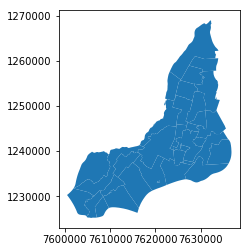

In [57]:
mtl_regions.plot()

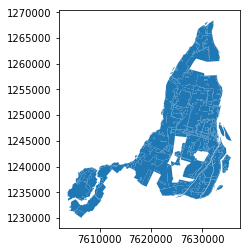

In [58]:
# 578 sectors?
mtl_land_use.plot()

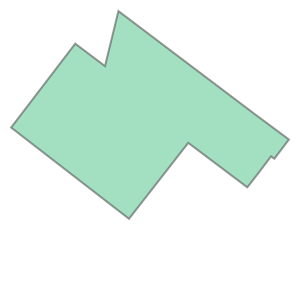

In [67]:
mtl_land_use.geometry[0]

# make rush-hour and downtown labels

In [26]:
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

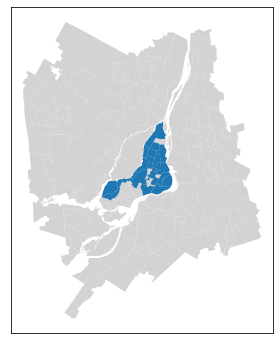

In [33]:
fig, ax = plt.subplots(1, figsize=(10,6))
mtl_region.plot(color='lightgrey',ax=ax);
city_of_montreal.plot(ax=ax);
ax.set_xticks([]);
ax.set_yticks([]);

In [38]:
# convert the point columns back into a Point class
%%time
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

In [3]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)
gdf['starthour'] = gdf.starttime.apply(lambda tm: tm.hour)
gdf['endhour'] = gdf.starttime.apply(lambda tm: tm.hour)

In [56]:
%%time
gdf['start_downtown'] = gdf['start_can'].apply(lambda row: any(city_of_montreal.intersects(row)))
gdf['end_downtown'] = gdf['end_can'].apply(lambda row: any(city_of_montreal.intersects(row)))

In [93]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry,start_downtown,end_downtown,starthour,endhour
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...,True,True,0,0
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...,True,True,2,2
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...,False,True,5,5
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,True,True,6,6
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...,False,False,6,6


In [63]:
print(gdf.start_downtown.value_counts())
print(gdf.end_downtown.value_counts())

True     159522
False     25763
Name: start_downtown, dtype: int64
True     158477
False     26808
Name: end_downtown, dtype: int64


In [96]:
gdf['weekday'] = gdf.starttime.apply(lambda dt: dt.dayofweek < 5)

In [98]:
gdf.weekday.value_counts()

True     139421
False     45864
Name: weekday, dtype: int64

In [4]:
rush_hour_times = {'morning_min':6,'morning_max':10,'evening_min':15, 'evening_max':19}
def rushhour(row):
    """
    function to find out whether trip is in rush hour or not
    """
    start = False
    end = False
    through = False
    if not row.weekday:
        return start, end
    
    if row.starttime.hour >= rush_hour_times['morning_min'] and row.starttime.hour <= rush_hour_times['morning_max']\
    or row.starttime.hour >= rush_hour_times['evening_min'] and row.starttime.hour <= rush_hour_times['evening_max']:
        start = True
    if row.endtime.hour >= rush_hour_times['morning_min'] and row.endtime.hour <= rush_hour_times['morning_max']\
    or row.endtime.hour >= rush_hour_times['evening_min'] and row.endtime.hour <= rush_hour_times['evening_max']:
        end = True
        
    # check if trip passed through rush hours  
    if start and end:
        if row.starttime.hour >= rush_hour_times['morning_min'] and row.endtime.hour <= rush_hour_times['morning_max']\
        or row.starttime.hour >= rush_hour_times['evening_min'] and row.endtime.hour <= rush_hour_times['evening_max']:
            through = True
        
        
    return start, end, through
    

In [5]:
gdf['stend_rh'] = gdf.apply(rushhour, axis=1)

In [6]:
gdf

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,weekday,start_rush,end_rushho,through_ru,start_wgs,end_wgs,start_can,end_can,geometry,stend_rh
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,1.900323e-02,WNW,...,1,0,1,2,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...,"(False, False, False)"
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,3.135046e-01,W,...,1,0,1,2,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...,"(False, False, False)"
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,2.721037e-01,SE,...,1,0,1,2,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...,"(False, True, False)"
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,3.040857e-01,E,...,1,0,1,2,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,"(True, True, True)"
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,2.554853e-01,E,...,1,0,1,2,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...,"(True, True, True)"
5,421155,None,None,2017-09-18 06:42:13-04:00,2017-09-18 06:45:16-04:00,183,530.737088,66.286377,3.251784e-01,ENE,...,1,0,1,2,POINT (-73.45155700000004 45.74749099999982),POINT (-73.44648500000002 45.7488929999998),POINT (7632650.98172996 1273797.68928672),POINT (7632989.362858895 1274063.356276445),"LINESTRING (7632650.98172996 1273797.68928672,...","(True, True, True)"
6,29064,None,None,2017-09-18 06:47:52-04:00,2017-09-18 06:49:34-04:00,102,90.537212,225.258580,4.075197e-01,SW,...,1,0,1,2,POINT (-73.56574500000005 45.51009499999979),POINT (-73.56641300000003 45.51001499999981),POINT (7631610.128197737 1245567.675562556),POINT (7631561.883890274 1245543.987149366),(LINESTRING (7631626.545535451 1245629.5916483...,"(True, True, True)"
7,203781,None,None,2017-09-18 06:53:49-04:00,2017-09-18 07:16:31-04:00,1362,8605.960727,123.191659,3.256624e-01,ESE,...,1,0,1,2,POINT (-73.56183100000007 45.51437399999979),POINT (-73.56330200000005 45.51500699999978),POINT (7631770.802031942 1246118.630389794),POINT (7631638.671248137 1246153.989722969),(LINESTRING (7623626.441304226 1247943.3070560...,"(True, True, True)"
8,273549,None,None,2017-09-18 06:54:50-04:00,2017-09-18 07:08:43-04:00,833,11432.721024,13.240337,2.935558e-01,NNE,...,1,0,1,2,POINT (-73.44588800000005 45.7523189999998),POINT (-73.42086200000004 45.82959999999981),POINT (7632924.248795619 1274446.797314812),POINT (7632326.330171747 1283354.4540747),LINESTRING (7632924.248795619 1274446.79731481...,"(True, True, True)"
9,314196,None,None,2017-09-18 06:57:01-04:00,2017-09-18 07:23:51-04:00,1610,7770.617747,34.373388,2.572517e-01,NE,...,1,0,1,2,POINT (-73.66851600000004 45.44199299999978),POINT (-73.62876200000002 45.47846499999979),POINT (7625960.44123376 1235889.569612722),POINT (7627825.844729592 1240729.001491461),LINESTRING (7625960.44123376 1235889.569612722...,"(True, True, True)"


In [11]:
%%time
gdf_rushhour = gdf['stend_rh'].apply(pd.Series)

CPU times: user 39.7 s, sys: 1.29 s, total: 41 s
Wall time: 42.8 s


In [18]:
gdf_rushhour.columns = ['startrush', 'endrush', 'thrurush']

In [21]:
gdf = pd.concat([gdf, gdf_rushhour], axis=1)

In [22]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,start_can,end_can,geometry,stend_rh,start_rushhour,end_rushhour,through_rushhour,startrush,endrush,thrurush
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,...,POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...,"(False, False, False)",0,1,2,False,False,False
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,...,POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...,"(False, False, False)",0,1,2,False,False,False
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,...,POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...,"(False, True, False)",0,1,2,False,True,False
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,...,POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,"(True, True, True)",0,1,2,True,True,True
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,...,POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...,"(True, True, True)",0,1,2,True,True,True


In [23]:
gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_down","end_downto","starthour","endhour","weekday","startrush","endrush", "thrurush","start_wgs","end_wgs","start_can","end_can", "geometry"]]

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,endhour,weekday,startrush,endrush,thrurush,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,1.900323e-02,WNW,...,0,1,False,False,False,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,3.135046e-01,W,...,2,1,False,False,False,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,2.721037e-01,SE,...,5,1,False,True,False,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,3.040857e-01,E,...,6,1,True,True,True,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,2.554853e-01,E,...,6,1,True,True,True,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...
5,421155,None,None,2017-09-18 06:42:13-04:00,2017-09-18 06:45:16-04:00,183,530.737088,66.286377,3.251784e-01,ENE,...,6,1,True,True,True,POINT (-73.45155700000004 45.74749099999982),POINT (-73.44648500000002 45.7488929999998),POINT (7632650.98172996 1273797.68928672),POINT (7632989.362858895 1274063.356276445),"LINESTRING (7632650.98172996 1273797.68928672,..."
6,29064,None,None,2017-09-18 06:47:52-04:00,2017-09-18 06:49:34-04:00,102,90.537212,225.258580,4.075197e-01,SW,...,6,1,True,True,True,POINT (-73.56574500000005 45.51009499999979),POINT (-73.56641300000003 45.51001499999981),POINT (7631610.128197737 1245567.675562556),POINT (7631561.883890274 1245543.987149366),(LINESTRING (7631626.545535451 1245629.5916483...
7,203781,None,None,2017-09-18 06:53:49-04:00,2017-09-18 07:16:31-04:00,1362,8605.960727,123.191659,3.256624e-01,ESE,...,6,1,True,True,True,POINT (-73.56183100000007 45.51437399999979),POINT (-73.56330200000005 45.51500699999978),POINT (7631770.802031942 1246118.630389794),POINT (7631638.671248137 1246153.989722969),(LINESTRING (7623626.441304226 1247943.3070560...
8,273549,None,None,2017-09-18 06:54:50-04:00,2017-09-18 07:08:43-04:00,833,11432.721024,13.240337,2.935558e-01,NNE,...,6,1,True,True,True,POINT (-73.44588800000005 45.7523189999998),POINT (-73.42086200000004 45.82959999999981),POINT (7632924.248795619 1274446.797314812),POINT (7632326.330171747 1283354.4540747),LINESTRING (7632924.248795619 1274446.79731481...
9,314196,None,None,2017-09-18 06:57:01-04:00,2017-09-18 07:23:51-04:00,1610,7770.617747,34.373388,2.572517e-01,NE,...,6,1,True,True,True,POINT (-73.66851600000004 45.44199299999978),POINT (-73.62876200000002 45.47846499999979),POINT (7625960.44123376 1235889.569612722),POINT (7627825.844729592 1240729.001491461),LINESTRING (7625960.44123376 1235889.569612722...


In [24]:
gdf['starttime'] = gdf['starttime'].astype(str)
gdf['endtime'] = gdf['endtime'].astype(str)
gdf['start_wgs'] = gdf['start_wgs'].astype(str)
gdf['start_can'] = gdf['start_can'].astype(str)
gdf['end_wgs'] = gdf['end_wgs'].astype(str)
gdf['end_can'] = gdf['end_can'].astype(str)

In [25]:
# gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_down","end_downto","starthour","endhour","weekday","startrush","endrush", "thrurush","start_wgs","end_wgs","start_can","end_can", "geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.json", encoding='utf-8', driver='GeoJSON')

In [26]:
# gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_down","end_downto","starthour","endhour","weekday","startrush","endrush", "thrurush","start_wgs","end_wgs","start_can","end_can", "geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')

## Land Use:

In [3]:
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')

In [4]:
mtl_land_use['area'] = mtl_land_use.geometry.area

In [5]:
mtl_land_use_km2 = np.sqrt(mtl_land_use.groupby('categorie').agg({'area':'sum'})/1000)

In [6]:
((mtl_land_use_km2 / mtl_land_use_km2.sum())*100)

,area
categorie,
agricultural,6.382143
conservation,8.853389
diversified activities,6.806435
employment,16.660439
infrastructure,8.120886
institution,5.196228
mixed,8.188347
park,9.089813
religious,2.843160


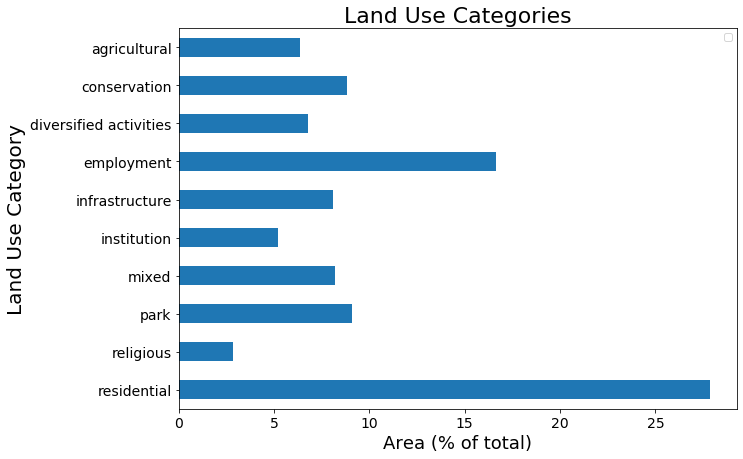

In [7]:
fig, ax = plt.subplots(1, figsize=(10,7))
((mtl_land_use_km2 / mtl_land_use_km2.sum())*100).plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_title("Land Use Categories", size=22)
ax.set_ylabel("Land Use Category", size=20)
plt.xticks(size=14)
plt.yticks(size=14)
ax.set_xlabel("Area (% of total)", size=18)
plt.legend([])
# plt.savefig('figures/land_use_category_bar_perc.png', bbox_inches='tight')

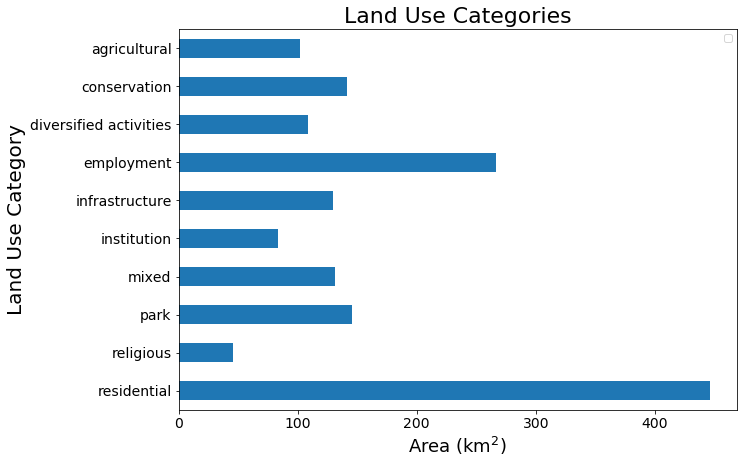

In [8]:
fig, ax = plt.subplots(1, figsize=(10,7))
mtl_land_use_km2.plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_title("Land Use Categories", size=22)
ax.set_ylabel("Land Use Category", size=20)
plt.xticks(size=14)
plt.yticks(size=14)
ax.set_xlabel("Area (km$^2$)", size=18)
plt.legend([])
# plt.savefig('figures/land_use_category_bar.png', bbox_inches='tight')

In [9]:
valid_mtl_land_use = mtl_land_use.apply(lambda row: row if row['geometry'].is_valid else None, axis=1).dropna()
valid_mtl_land_use.head()

,categorie,geometry,area
0,mixed,(POLYGON Z ((7623249.762010538 1253009.9219910...,4.635218e+04
1,residential,(POLYGON Z ((7624215.607022332 1257355.0978382...,3.882296e+07
2,diversified activities,(POLYGON Z ((7624135.136503022 1252033.1915981...,2.706401e+04
3,diversified activities,(POLYGON Z ((7624481.967422946 1252054.1298312...,6.420532e+04
4,mixed,(POLYGON Z ((7624376.445011825 1252119.6806659...,2.775483e+05


In [63]:
def get_land_use(row, mtl_land_use=valid_mtl_land_use):
    ov_land_use = []
    flatten = lambda l: [item for sublist in l for item in sublist]
    if type(row['geometry']) == shapely.geometry.multilinestring.MultiLineString:
        for row_ind in row['geometry']:
            try:
#                 if row['geometry'][row_ind].is_valid:
                inter_geom = find_intersection(row_ind, mtl_land_use)
                if inter_geom:
                    ov_land_use.append(inter_geom)
            except:
                pass
        return flatten(ov_land_use)
    else:
#         if row['geometry'].is_valid:
        land_use = find_intersection(row['geometry'], mtl_land_use)
        return land_use
        
def find_intersection(row_geom, mtl_land_use):
    land_use = []
    for i in mtl_land_use.iterrows(): 
#         if :
            try:
                if row_geom.intersects(i[1]['geometry']):
                    intersect_land = gpd.sjoin(gpd.GeoDataFrame([row_geom], columns=['geometry']), gpd.GeoDataFrame([i[1]]), how='right', op='intersects')
        #             intersect_land.dropna(subset=['id_trip'], inplace=True)
                    land_use.append(list(intersect_land.categorie.values))
            except:
                pass
    if len(land_use) > 0:
        return list(list(zip(*land_use))[0])

In [10]:
gdf_drop = gdf.dropna(subset=['purpose'])

In [11]:
len(gdf_drop)

74218

In [71]:
375 / 60

6.25

In [66]:
%%time
# 100th == 
gdf_drop.loc[:1000].apply(get_land_use, axis=1)

CPU times: user 2min 24s, sys: 1.24 s, total: 2min 25s
Wall time: 2min 27s


3      [residential, employment, diversified activiti...
13                                                  None
15     [mixed, residential, residential, institution,...
16     [institution, residential, institution, instit...
19     [employment, religious, mixed, mixed, diversif...
                             ...                        
991                                                   []
992                    [institution, mixed, residential]
994                                 [residential, mixed]
995    [residential, employment, residential, diversi...
999              [institution, institution, residential]
Length: 494, dtype: object

In [35]:
gpd.GeoDataFrame(a, columns=['geometry'])

,geometry
3,(POLYGON Z ((7624215.607022332 1257355.0978382...


In [72]:
%%time
gdf_drop['land_use'] = gdf_drop.apply(get_land_use, axis=1)

CPU times: user 7h 30s, sys: 3min 39s, total: 7h 4min 9s
Wall time: 7h 21min 26s


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
print("done!")

done!


In [83]:
gdf_drop['land_use'] = gdf_drop['land_use'].astype(str)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
gdf_drop.to_file('../app_route_data/land_use_mtl_trajet.shp', encoding='utf-8')

In [87]:
a = gpd.read_file('../app_route_data/land_use_mtl_trajet.shp')

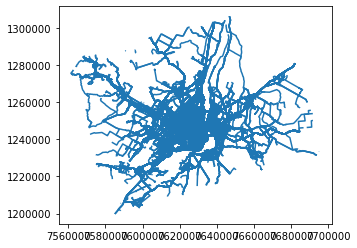

In [88]:
a.plot()

In [91]:
a.land_use[0]

"['residential', 'employment', 'diversified activities', 'residential', 'mixed']"

In [85]:
gdf_drop.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,endrush,thrurush,lda_word,temporal_c,start_wgs,end_wgs,start_can,end_can,geometry,land_use
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,...,1,1,"Monday_6, pick_up_a_person",5,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,"['residential', 'employment', 'diversified act..."
13,173651,car,work,2017-09-18 07:14:10-04:00,2017-09-18 08:01:46-04:00,2856,15283.760539,171.872470,0.232414,S,...,1,1,"Monday_7, work",5,POINT (-73.81487200000002 45.64468299999982),POINT (-73.80018800000005 45.55683299999981),POINT (7608401.68239975 1254568.515455438),POINT (7612292.411519157 1245384.496834899),LINESTRING (7608401.68239975 1254568.515455438...,None
15,81386,"walking, public_transport",work,2017-09-18 07:17:04-04:00,2017-09-18 08:07:27-04:00,3023,7757.762316,169.163581,0.121941,S,...,1,1,"Monday_7, work",5,POINT (-73.61387700000004 45.53915899999978),POINT (-73.55234900000006 45.4661039999998),POINT (7627021.071964022 1247630.119465985),POINT (7634038.297039393 1241110.561616503),(LINESTRING (7627033.970862066 1247936.1648094...,"['mixed', 'residential', 'residential', 'insti..."
16,149086,public_transport,work,2017-09-18 07:20:42-04:00,2017-09-18 08:10:14-04:00,2972,7693.525202,170.378606,0.048575,S,...,1,1,"Monday_7, work",5,POINT (-73.56351300000006 45.51644699999981),POINT (-73.56519900000005 45.5008869999998),POINT (7631576.524534984 1246305.001546624),POINT (7631946.431465326 1244583.906550724),LINESTRING (7631576.524534984 1246305.00154662...,"['institution', 'residential', 'institution', ..."
19,358412,walking,work,2017-09-18 07:27:38-04:00,2017-09-18 07:40:26-04:00,768,992.314303,211.576183,0.347807,SSW,...,1,1,"Monday_7, work",5,POINT (-73.59024400000006 45.53260999999979),POINT (-73.59427000000002 45.52622499999982),POINT (7629026.972989381 1247452.25399864),POINT (7628924.956414173 1246671.107441435),LINESTRING (7629026.972989381 1247452.25399864...,"['employment', 'religious', 'mixed', 'mixed', ..."


In [101]:
# gdf = gdf.merge(gdf_drop[["id_trip","land_use"]], on='id_trip', how='left')

In [106]:
gdf[['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds', 'distance_m',\
 'direction', 'magnitude', 'carddir', 'start_down', 'end_downto', 'starthour',\
 'endhour', 'weekday', 'startrush', 'endrush', 'thrurush', 'lda_word', 'temporal_c',\
 'precip', 'temperatur', 'land_use', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry']]#
#.to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')